# Delayed SIR model
### Reference
  * https://www.fttsus.jp/covinfo/numerical-simulation/
  
### Library
* https://github.com/Zulko/ddeint

In [9]:
!pwd
!curl -O https://data.covid19japan.com/summary/latest.json

/Users/hide/_projects/jupyter_notebooks/COVID-19/COVID-modeling
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 93712  100 93712    0     0   122k      0 --:--:-- --:--:-- --:--:--  122k


In [10]:
import json
import pandas as pd

from ddeint import ddeint
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter

import optuna
from sklearn.metrics import mean_squared_error, mean_squared_log_error

In [11]:
def load_real_data():
    with open('latest.json', 'r') as f:
        data = json.loads(f.read())
    df = pd.DataFrame(data['daily'])
    df['date'] = pd.to_datetime(df['date'])
    df.set_index('date', inplace=True)
    
    df['exitedCumulative'] = df['recoveredCumulative'] + df['deceasedCumulative']
    df['activeCumulative'] = df['confirmedCumulative'] - df['exitedCumulative']
    
    df['tested'] = df['testedCumulative'] - df['testedCumulative'].shift()
    df['active'] = df['activeCumulative'] - df['activeCumulative'].shift()
    df['tested'] = df[df['tested'] > 10]['tested']
    df['tested'] = df['tested'].interpolate()

    df['activeTestedCumulativeRate'] = df['activeCumulative'] / df['testedCumulative']
    df['activeTestedRate'] = df['active'] / df['tested']
    return df

load_real_data().loc['2020-02-28'].transpose().sort_index()

active                          14.000000
activeCumulative               187.000000
activeTestedCumulativeRate       0.084654
activeTestedRate                 0.092715
confirmed                       18.000000
confirmedAvg3d                  20.000000
confirmedAvg7d                  17.000000
confirmedCumulative            233.000000
confirmedCumulativeAvg3d       203.000000
confirmedCumulativeAvg7d       167.000000
criticalCumulative              20.000000
deceasedCumulative               5.000000
exitedCumulative                46.000000
recoveredCumulative             41.000000
tested                         151.000000
testedCumulative              2209.000000
Name: 2020-02-28 00:00:00, dtype: float64

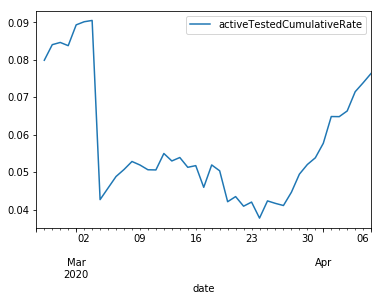

In [12]:
load_real_data()[['activeTestedCumulativeRate']].loc['2020-02-25':].plot()

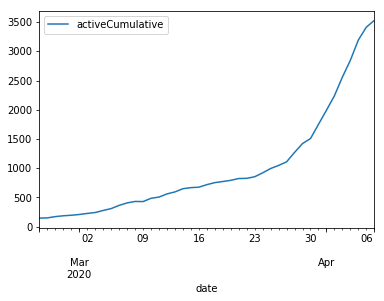

In [13]:
load_real_data()[['activeCumulative']].loc['2020-02-25':].plot()

In [14]:
'''
* Infection rate -> alpha (beta in original SIR model)
* Recovery rate -> beta (gamma in original SIR model)
* Relayed -> gamma
* Fatality rate -> fatality_rate
'''

def model(Y, t):
    '''SIR Model'''
    global alpha, beta, gamma, fatality_rate
    S, I, R, D, Rr = Y(t)
    Sd, Id, Rd, Dd, Rrd = Y(t-gamma)
    dSdt = -alpha * S * I / N
    dIdt = alpha * Sd * Id / N - beta * I
    dRdt = beta * I
    dDdt = fatality_rate * dRdt
    dRrdt = (1 - fatality_rate) * dRdt
    return np.array([
        dSdt, dIdt, dRdt, dDdt, dRrdt
    ])

# Initial values
alpha = 0.29
beta = 0.035
gamma = 14
fatality_rate = 0.1
N = 126_100_000
S0 = N
I0 = 26
D0 = 0
Rr0 = 0
R0 = D0 + Rr0

start_date = '2020-02-10'
end_date = '2020-04-06'
date_range = pd.date_range(start_date, end_date, freq='d')
t_max = len(date_range)

init_state = lambda t: np.array([S0, I0, R0, D0, Rr0])
tt = np.linspace(0.0, t_max, t_max+1)

# DDE
yy = ddeint(model, init_state, tt)

def objective(trial):
    global alpha, beta, gamma, fatality_rate

    alpha = trial.suggest_uniform('alpha', 0.1, 0.5)
    beta = trial.suggest_loguniform('beta', 0.01, 0.05)
    gamma = trial.suggest_uniform('gamma', 8, 30)
    fatality_rate = trial.suggest_uniform('fatality_rate', 0.01, 0.2)
    yy = ddeint(model, init_state, tt)
    return (
        mean_squared_log_error(yy[:,1][1:], load_real_data().loc[start_date:end_date]['activeCumulative'])
        + mean_squared_log_error(yy[:,2][1:], load_real_data().loc[start_date:end_date]['exitedCumulative'])
        + mean_squared_log_error(yy[:,3][1:], load_real_data().loc[start_date:end_date]['deceasedCumulative'])
        + mean_squared_log_error(yy[:,4][1:], load_real_data().loc[start_date:end_date]['recoveredCumulative'])
    )

optuna.logging.disable_default_handler()
study = optuna.create_study()
study.optimize(objective, n_trials=100)
print("best_value = ", study.best_value)
print("best_params = ", study.best_params)

best_value =  0.4633025178371615
best_params =  {'alpha': 0.41039350733927954, 'beta': 0.02195413355540045, 'gamma': 20.493131823962898, 'fatality_rate': 0.09645661303481115}


In [15]:
# Initial values
alpha = study.best_params['alpha']
beta = study.best_params['beta']
gamma = study.best_params['gamma']
fatality_rate = study.best_params['fatality_rate']

end_date = '2020-04-20'
date_range = pd.date_range(start_date, end_date, freq='d')
t_max = len(date_range)-1

tt = np.linspace(0.0, t_max, t_max+1)

new_yy = ddeint(model, init_state, tt)

def make_df(yy, start_date):
    df = pd.DataFrame(yy[:, 1:3], columns=['pred_I', 'pred_R'])
    df.index = date_range
    df['pred_D'] = fatality_rate * df['pred_R']
    df['pred_Rr'] = (1-fatality_rate) * df['pred_R']
    return df

# def make_df_with_f_rate(yy, start_date):
#     df = pd.DataFrame(yy[:, 1:5], columns=['pred_I', 'pred_R', 'pred_D', 'pred_Rr'])
#     df.index = date_range
#     return df

# Create real & prediction DF
pred_df = make_df(new_yy, start_date)
real_df = load_real_data()
combined_df = pd.merge(pred_df,
                       real_df,
                       left_index=True,
                       right_index=True,
                       how='outer')

combined_df.loc['2020-04-15'].transpose()

pred_I                        5569.440302
pred_R                        1553.858493
pred_D                         149.879927
pred_Rr                       1403.978565
confirmed                             NaN
recoveredCumulative                   NaN
deceasedCumulative                    NaN
criticalCumulative                    NaN
testedCumulative                      NaN
confirmedCumulative                   NaN
confirmedAvg3d                        NaN
confirmedCumulativeAvg3d              NaN
confirmedAvg7d                        NaN
confirmedCumulativeAvg7d              NaN
exitedCumulative                      NaN
activeCumulative                      NaN
tested                                NaN
active                                NaN
activeTestedCumulativeRate            NaN
activeTestedRate                      NaN
Name: 2020-04-15 00:00:00, dtype: float64

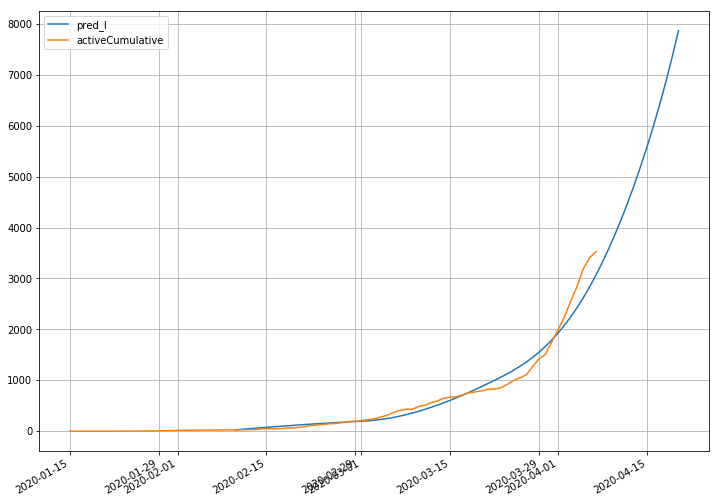

In [16]:
COLUMNS = ['pred_I', 'activeCumulative']

fig, ax = plt.subplots(figsize=(12,9))
combined_df[COLUMNS].plot(ax=ax, grid=True)
plt.show()

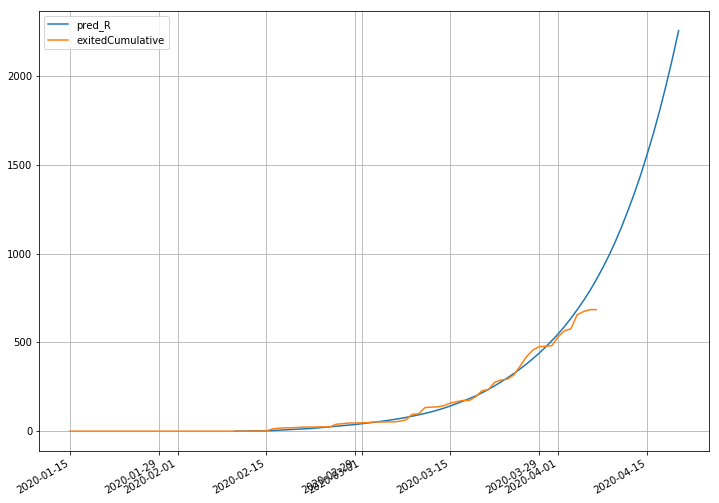

In [17]:
COLUMNS = ['pred_R', 'exitedCumulative']

fig, ax = plt.subplots(figsize=(12,9))
combined_df[COLUMNS].plot(ax=ax, grid=True)
plt.show()

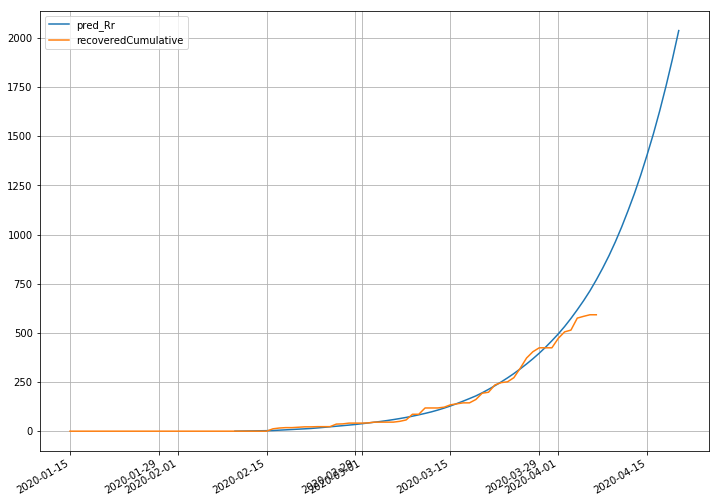

In [18]:
COLUMNS = ['pred_Rr', 'recoveredCumulative']

fig, ax = plt.subplots(figsize=(12,9))
combined_df[COLUMNS].plot(ax=ax, grid=True)
plt.show()

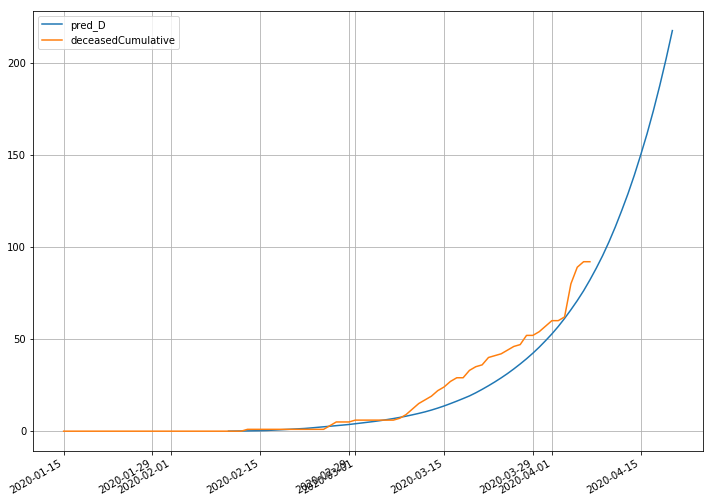

In [19]:
COLUMNS = ['pred_D', 'deceasedCumulative']

fig, ax = plt.subplots(figsize=(12,9))
combined_df[COLUMNS].plot(ax=ax, grid=True)
plt.show()